# This notebook includes the code used to create and train the DeepAgent.
The code is based on <reference> where a deep learning model was trained to play regular tic-tac-toe, but we adapted it to work for our 3-d tic-tac-toe variation.

## Imports

In [1]:
import random
import copy
import tensorflow as tf
import numpy as np
import csv
import os
from pathlib import Path
from tabulate import tabulate
from abc import abstractmethod
import keras.layers as Kl
import keras.models as Km
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

## Piece Class

In [2]:
# Stores the possible pieces to play as in an enum.
class Piece(Enum):
    EMPTY = 'EMPTY'
    BLACK = 'BLACK'
    WHITE = 'WHITE'
    RED = ' RED '

# TicTacToe Class


In [3]:
# represents a game, or series of games, of tic-tac-toe. Keeps track of the current "board" state, players 
# 1 and 2, whose turn it is, as well as the winner of each game and how many 
# games each player has won
class TicTacToe():

    def __init__(self, player1, player2, model_path_1,model_path_2, exp1=1, exp2=1):
        self.state = [[[Piece.EMPTY for k in range(3)] for j in range(3)] for i in range(3)]
        self.winningRuns = self.getWinningRuns()
        
        if player1 == "DeepAgent":
            player1 = globals()[player1]
            self.player1 = player1(model_path_1, tag=Piece.WHITE, exploration_factor=exp2)
        else:
            player1 = globals()[player1]
            self.player1 = player1(tag=Piece.WHITE, exploration_factor=exp1)
        if player2 == "DeepAgent":
          player2 = globals()[player2]
          self.player2 = player2(model_path_2, tag=Piece.BLACK, exploration_factor=exp2)
        else:
          player2 = globals()[player2]
          self.player2 = player2(tag=Piece.BLACK, exploration_factor=exp2)

        self.winner = None
        self.turn = Piece.WHITE
        self.player_turn = self.player1

        self.White_win_count = 0
        self.Black_win_count = 0
        self.Tcount = 0
        self.all_count = 0


    def getWinningRuns(self):
      """ Returns all the possible winning runs.
      """
      runs = []

      runs.append([(0,0,0),(0,0,1),(0,0,2)])
      runs.append([(0,0,0),(0,1,0),(0,2,0)])
      runs.append([(0,0,0),(1,0,0),(2,0,0)])

      runs.append([(2,2,0),(1,2,0),(0,2,0)])
      runs.append([(2,2,0),(2,1,0),(2,0,0)])
      runs.append([(2,2,0),(2,2,1),(2,2,2)])

      runs.append([(0,2,2),(0,1,2),(0,0,2)])
      runs.append([(0,2,2),(1,2,2),(2,2,2)])
      runs.append([(0,2,2),(0,2,1),(0,2,0)])

      runs.append([(2,0,2),(2,0,1),(2,0,0)])
      runs.append([(2,0,2),(1,0,2),(0,0,2)])
      runs.append([(2,0,2),(2,1,2),(2,2,2)])
      # Front
      runs.append([(0,0,0),(1,0,1),(2,0,2)])
      runs.append([(0,0,2),(1,0,1),(2,0,0)])
      runs.append([(1,0,0),(1,0,1),(1,0,2)])
      runs.append([(0,0,1),(1,0,1),(2,0,1)])
      # Top
      runs.append([(0,0,0),(1,1,0),(2,2,0)])
      runs.append([(0,2,0),(1,1,0),(2,0,0)])
      runs.append([(0,1,0),(1,1,0),(2,1,0)])
      runs.append([(1,2,0),(1,1,0),(1,0,0)])
      # Left
      runs.append([(0,0,0),(0,1,1),(0,2,2)])
      runs.append([(0,0,2),(0,1,1),(0,2,0)])
      runs.append([(0,0,1),(0,1,1),(0,2,1)])
      runs.append([(0,1,0),(0,1,1),(0,1,2)])
      # Back
      runs.append([(0,2,2),(1,2,1),(2,2,0)])
      runs.append([(0,2,0),(1,2,1),(2,2,2)])
      runs.append([(1,2,0),(1,2,1),(1,2,2)])
      runs.append([(0,2,1),(1,2,1),(2,2,1)])
      # Right
      runs.append([(2,0,2),(2,1,1),(2,2,0)])
      runs.append([(2,0,0),(2,1,1),(2,2,2)])
      runs.append([(2,0,1),(2,1,1),(2,2,1)])
      runs.append([(2,1,0),(2,1,1),(2,1,2)])
      # Bottom
      runs.append([(2,0,2),(1,1,2),(0,2,2)])
      runs.append([(0,0,2),(1,1,2),(2,2,2)])
      runs.append([(0,1,2),(1,1,2),(2,1,2)])
      runs.append([(1,0,2),(1,1,2),(1,2,2)])
      # Corners
      runs.append([(0,0,0),(1,1,1),(2,2,2)])
      runs.append([(2,0,0),(1,1,1),(0,2,2)])
      runs.append([(2,2,0),(1,1,1),(0,0,2)])
      runs.append([(0,2,0),(1,1,1),(2,0,2)])
      # Edges
      runs.append([(1,0,0),(1,1,1),(1,2,2)])
      runs.append([(2,1,0),(1,1,1),(0,1,2)])
      runs.append([(1,2,0),(1,1,1),(1,0,2)])
      runs.append([(0,1,0),(1,1,1),(2,1,2)])
      runs.append([(0,0,1),(1,1,1),(2,2,1)])
      runs.append([(2,0,1),(1,1,1),(0,2,1)])
      # Middles
      runs.append([(1,1,0),(1,1,1),(1,1,2)])
      runs.append([(1,0,1),(1,1,1),(1,2,1)])
      runs.append([(0,1,1),(1,1,1),(2,1,1)])

      return runs

    def play_game(self):
        """ Executes a single game of 3d tictactoe. Alternates between players
        making moves until a winner is found, or a tie occurs (no more possible
        moves and no winner). Deep agent does not learn with this method.
        """
        while self.winner is None:
            # if type(self.player_turn) == Player:
            # self.print_game()

            self.state = self.play_move()
            self.game_winner()

            if self.winner is not None:
                break

        # self.print_game()
        return self.winner

    def play_to_learn(self, episodes):
        """ Executes a single game of 3d tictactoe. Alternates between players
        making moves until a winner is found, or a tie occurs (no more possible
        moves and no winner). Deep agent does will learn every time it makes a move
        by training the model with the new game state. Prints game summary.
        """
        for i in range(episodes):
            print('Episode number: ' + str(i))

            while 1 == 1:
                self.state = self.play_move(learn=True)
                self.game_winner()
                if self.winner is not None:
                    break

                
                self.state = self.play_move(learn=True)
                self.game_winner()
                if self.winner is not None:
                  print(self.winner)
                  break

            # update last state
            self.state = self.play_move(learn=True)
            self.state = self.play_move(learn=True)
            # # update winning state
            # self.state = self.play_move(learn=True)
            # self.state = self.play_move(learn=True)
            if type(self.player1) == DeepAgent:
                self.player1.save_values()

            if type(self.player2) == DeepAgent:
                self.player2.save_values()
            if i% 500 == 0:
                self.print_bar_graph()
                print('-------------------')
                self.player1.print_value = True
            else:
                self.player1.print_value = False

            self.all_count = i
            self.init_game()

        self.print_summary()
        if type(self.player1) == DeepAgent:
            self.player1.save_values()
            
        if type(self.player2) == DeepAgent:
            self.player2.save_values()

    def play_move(self, learn=False):
        """ Calls either make_move_and_learn or make_move, depening on whether
        the deep model should learn, and returns the new state that that method
        decides. Also updates player turn info to the next player.
        """
        if self.turn == Piece.WHITE:
            if (learn is True) & (type(self.player1) == DeepAgent):
                new_state = self.player1.make_move_and_learn(self.state, self.winner)
            else:
                new_state = self.player1.make_move(self.state, self.winner)
            self.turn = Piece.BLACK
            self.player_turn = self.player2
        elif self.turn == Piece.BLACK:
            if (learn is True) & (type(self.player2) == DeepAgent):
                new_state = self.player2.make_move_and_learn(self.state, self.winner)
            else:
                new_state = self.player2.make_move(self.state, self.winner)
            self.turn = Piece.WHITE
            self.player_turn = self.player1
        return new_state

    def print_game(self):
        """ Prints the game board in its current state
        """
        gamestate = "+----------------------\n"
        gamestate += "| \ " + self.state[0][2][0].value + "  " + self.state[1][2][0].value + "  " + self.state[2][2][0].value + " \\\n"
        gamestate += "|   \                     \\\n"
        gamestate += "|     \ " + self.state[0][1][0].value + "  " + self.state[1][1][0].value + "  " + self.state[2][1][0].value + " \\\n"
        gamestate += "|       \                     \\\n"
        gamestate += "|         \ " + self.state[0][0][0].value + "  " + self.state[1][0][0].value + "  " + self.state[2][0][0].value + " \\\n"
        gamestate += "|          ---------------------|\n"
        gamestate += "|   " + self.state[0][2][1].value + " |" + self.state[1][2][1].value + "  " + self.state[2][2][1].value + "         |\n"
        gamestate += "|         |                     |\n"
        gamestate += "|       " + self.state[0][1][1].value + "  " + self.state[1][1][1].value + "  " + self.state[2][1][1].value + "     |\n"
        gamestate += "|         |                     |\n"
        gamestate += "|         | " + self.state[0][0][1].value + "  " + self.state[1][0][1].value + "  " + self.state[2][0][1].value + " |\n"
        gamestate += "|         |                     |\n"
        gamestate += " \ " + self.state[0][2][2].value + "  " + self.state[1][2][2].value + "  " + self.state[2][2][2].value + "          |\n"
        gamestate += "   \      |                     |\n"
        gamestate += "     \ " + self.state[0][1][2].value + "  " + self.state[1][1][2].value + "  " + self.state[2][1][2].value + "      |\n"
        gamestate += "       \  |                     |\n"
        gamestate += "         \| " + self.state[0][0][2].value + "  " + self.state[1][0][2].value + "  " + self.state[2][0][2].value + " |\n"
        gamestate += "           ---------------------+\n\n"
        print(gamestate)

    
    def game_winner(self):
        """ Determines whether a winner has been found and who it is and updates
        self.winner to reflect who won. If nobody has won, but the game isnt over,
        does not update self.winner.
        """
        for run in self.winningRuns:
            if all((self.state[x][y][z] == Piece.WHITE) for (x,y,z) in run):
                self.winner = Piece.WHITE
            elif all((self.state[x][y][z] == Piece.BLACK) for (x,y,z) in run):
                self.winner = Piece.BLACK
            elif Piece.EMPTY not in np.array(self.state):
                self.winner= 'No winner'
        self.check_winner()
        return self.winner

    def check_winner(self):
        """ Updates win count values for each player based on who won the game
        """
        if self.winner == Piece.WHITE:
            self.White_win_count += 1
            print('The winner is White')
            print('')
            self.print_game()

        elif self.winner == Piece.BLACK:
            self.Black_win_count += 1
            print('The winner is Black')
            print('')
            self.print_game()

        elif self.winner == 'No winner':
            self.Tcount += 1
            print('No winner')
            print('')
            self.print_game()

    def init_game(self):
        """ This is called to reset the game state, who won, and next player so 
        another game of tictactoe can be played.
        """
        self.state = [[[Piece.EMPTY for k in range(3)] for j in range(3)] for i in range(3)]
        self.winner = None
        self.turn = Piece.WHITE
        self.player_turn = self.player1

    def print_bar_graph(self):
        """ Prints game statistic bar graphs.
        """
        plt.close()
        fig = plt.figure()
        ax1 = fig.add_subplot(2, 1, 1)
        ax2 = fig.add_subplot(2, 1, 2)

        x = ['White', 'Tie', 'Black', 'Sum']
        a = self.White_win_count
        b = self.Tcount
        c = self.Black_win_count
        d = self.all_count

        aprec = 100*a / (a + b + c + 1)
        bprec = 100*b / (a + b + c + 1)
        cprec = 100*c / (a + b + c + 1)

        ax1.clear()
        ax2.clear()
        bar1 = ax1.bar(x, [a, b, c, d])
        bar1[0].set_color('r')
        bar1[1].set_color('b')
        ax1.set_ylim((0, d + 100))
        plt.draw()

        bar2 = ax2.bar(x[0:3], [aprec, bprec, cprec])
        bar2[0].set_color('r')
        bar2[1].set_color('b')
        ax2.set_ylim((0, 100))

        for rect in bar2:
            height = rect.get_height()
            ax2.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
                    '%d' % int(height),
                    ha='center', va='bottom')

        plt.draw()

        plt.pause(0.05)

    def print_summary(self):
        """ Prints game statistics.
        """
        a = ['White',   self.White_win_count, 100 * self.White_win_count / (self.White_win_count + self.Black_win_count + self.Tcount)]
        b = ['Black',   self.Black_win_count, 100 * self.Black_win_count / (self.White_win_count + self.Black_win_count + self.Tcount)]
        c = ['Tie', self.Tcount, 100 * self.Tcount / (self.White_win_count + self.Black_win_count + self.Tcount)]
        tab = tabulate([a, b, c], headers=['Player', 'num of wins', 'prec'])
        print(tab)


# Player Class

In [4]:
# Represents a player and stores the tag, Player.WHITE or Player.BLACK,
# and exploration factor, how much player will explore. This class allows user
# Choose moves.
class Player():

    def __init__(self, tag, exploration_factor=1):
        self.tag = tag
        self.print_value = False
        self.exp_factor = exploration_factor
        
        
    def validMove(self,state,x,y,z,direction):
        """ Determines if a move is valid, returns True or False. 
        """
        if not x in range(3) or not y in range(3) or not z in range(3):
            return False
        if direction == 'UP':
            return (z == 2) and (state[x][y][z] == Piece.EMPTY or state[x][y][z-1] == Piece.EMPTY or state[x][y][z-2] == Piece.EMPTY)
        elif direction == 'DOWN':
            return (z == 0) and (state[x][y][z] == Piece.EMPTY or state[x][y][z+1] == Piece.EMPTY or state[x][y][z+2] == Piece.EMPTY)
        elif direction == 'LEFT':
            return (x == 2) and (state[x][y][z] == Piece.EMPTY or state[x-1][y][z] == Piece.EMPTY or state[x-2][y][z] == Piece.EMPTY)
        elif direction == 'RIGHT':
            return (x == 0) and (state[x][y][z] == Piece.EMPTY or state[x+1][y][z] == Piece.EMPTY or state[x+2][y][z] == Piece.EMPTY)
        elif direction == 'FRONT':
            return (y == 2) and (state[x][y][z] == Piece.EMPTY or state[x][y-1][z] == Piece.EMPTY or state[x][y-2][z] == Piece.EMPTY)
        elif direction == 'BACK':
            return (y == 0) and (state[x][y][z] == Piece.EMPTY or state[x][y+1][z] == Piece.EMPTY or state[x][y+2][z] == Piece.EMPTY)
        else:
            return False
            
    def move(self,state,x,y,z,direction,player: Piece):
        """ Executes move on board state if the move is valid. 
        """
        new_state = copy.deepcopy(state)

        if not self.validMove(state,x,y,z,direction):
            raise ValueError
        else:
            if (state[x][y][z] == Piece.EMPTY):
                new_state[x][y][z] = player
            else:
                if direction == 'UP':
                    if (state[x][y][z-1] == Piece.EMPTY):
                        new_state[x][y][z-1] = state[x][y][z]
                        new_state[x][y][z] = player
                    else:
                        new_state[x][y][z-2] = state[x][y][z-1]
                        new_state[x][y][z-1] = state[x][y][z]
                        new_state[x][y][z] = player
                elif direction ==  'DOWN':
                    if (state[x][y][z+1] == Piece.EMPTY):
                        new_state[x][y][z+1] = state[x][y][z]
                        new_state[x][y][z] = player
                    else:
                        new_state[x][y][z+2] = state[x][y][z+1]
                        new_state[x][y][z+1] = state[x][y][z]

                        new_state[x][y][z] = player
                elif direction == "LEFT":
                    if (state[x-1][y][z] == Piece.EMPTY):
                        new_state[x-1][y][z] = state[x][y][z]
                        new_state[x][y][z] = player
                    else:
                        new_state[x-2][y][z] = state[x-1][y][z]
                        new_state[x-1][y][z] = state[x][y][z]
                        new_state[x][y][z] = player
                elif direction == 'RIGHT':
                    if (state[x+1][y][z] == Piece.EMPTY):
                        new_state[x+1][y][z] = state[x][y][z]
                        new_state[x][y][z] = player
                    else:
                        new_state[x+2][y][z] = state[x+1][y][z]
                        new_state[x+1][y][z] = state[x][y][z]
                        new_state[x][y][z] = player
                elif direction == 'FRONT':
                    if (state[x][y-1][z] == Piece.EMPTY):
                        new_state[x][y-1][z] = state[x][y][z]
                        new_state[x][y][z] = player
                    else:
                        new_state[x][y-2][z] = state[x][y-1][z]
                        new_state[x][y-1][z] = state[x][y][z]
                        new_state[x][y][z] = player
                elif direction == 'BACK':
                    if (state[x][y+1][z] == Piece.EMPTY):
                        new_state[x][y+1][z] = state[x][y][z]
                        new_state[x][y][z] = player
                    else:
                        new_state[x][y+2][z] = state[x][y+1][z]
                        new_state[x][y+1][z] = state[x][y][z]
                        new_state[x][y][z] = player
        return new_state
                  
    def make_move(self, state, winner):
        """ Gets move from user and executes it.
        """
        x = int(input('Choose x: '))
        y = int(input('Choose y: '))
        z = int(input('Choose z: '))
        direction = str(input('Choose direction: '))
        # direction = random.choice(directions)
        
        # should this be modifying self.state or just returning new state?
        s = self.move(state, x,y,z,direction,self.tag)
        return s



# Agent Class

In [13]:
# represnts an agent player. This is a parent class for the deep learning agent
# and is not otherwise used. 
class Agent(Player):

    def __init__(self, tag, exploration_factor=1):
        super().__init__(tag, exploration_factor)
        self.epsilon = 0.1
        self.alpha = 0.5
        self.prev_state = [[[Piece.EMPTY for k in range(3)] for j in range(3)] for i in range(3)]
        self.state = [[[Piece.EMPTY for k in range(3)] for j in range(3)] for i in range(3)]
        self.print_value = False

    @abstractmethod
    def calc_value(self, state):
        pass

    @abstractmethod
    def learn_state(self, state, winner):
        print("passing")
        pass

    def getPossibleMoves(self, state):
        moves = []
        for x in range(0,3):
            for y in range(0,3):
                for z in range(0,3):
                    for direction in directions:
                        if self.validMove(state,x,y,z,direction):
                            moves.append((x,y,z,direction))
        return moves
                              
                              
    def make_move(self, state, winner):
        """ If a winner hasn't been found, makes an optimal move with probability
        self.exp_factor, otherwise makes a random move. Returns resulting state.
        """
        self.state = state
        if winner is not None:
            new_state = state
            return new_state

        p = random.uniform(0, 1)
        if p < self.exp_factor:
            new_state = self.make_optimal_move(state)
        else:
            moves = self.getPossibleMoves(state)
            (x,y,z,direction) = random.choice(moves)
            new_state = self.move(state,x,y,z,direction,self.tag)
        return new_state

    def make_move_and_learn(self, state, winner):
        """ Learns the given state with the model, then calls make move to 
        deterine what move to make
        """
        self.learn_state(state, winner)

        return self.make_move(state, winner)
                              
    def make_optimal_move(self, state):
        """ Uses the model to find the best move, makes the move, and returns 
        the resulting state. 
        """
        moves = self.getPossibleMoves(state)

        temp_state_list = []
        v = -float('Inf')

        temp_state_values = []
        for x,y,z,direction in moves:
            temp_state = copy.deepcopy(state)
            temp_state = self.move(temp_state,x,y,z,direction,self.tag)

            temp_state_value =self.calc_value(temp_state)
            temp_state_values.append(temp_state_value)
        
        optimal_move_index = np.argmax(temp_state_values)
        x,y,z,direction = moves[optimal_move_index]

        new_state = self.move(state,x,y,z,direction,self.tag)
        return new_state
                                  
    def reward(self, winner):
      """ Returns the reward of the winner. 
      """
      if winner is self.tag:
          R = 1
      elif winner is None:
          R = 0
      elif winner == 'No winner':
          R = 0.5
      else:
          R = -1
      return R


## DeepAgent Class

In [14]:
# Represent a deep-rl learning agent. Stores the super attributes as well as 
# the value model and path to the model. 
class DeepAgent(Agent):

    def __init__(self, model_path,tag,exploration_factor=1):
        super().__init__(tag, exploration_factor)
        self.tag = tag
        self.model_path=model_path
        self.value_model = self.load_model()

    def piece_to_num(self, piece):
        """ Converts a piece to a number
        """
        if piece == self.tag:
            return 1
        elif piece == Piece.EMPTY:
            return 0
        else:
            return -1

    def state2array(self, state):
        """ Converts a board state to an array that can be used by the model
        """
        state_as_array = []
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    state_as_array.append(self.piece_to_num(state[i][j][k]))
        return np.array(state_as_array)

    def learn_state(self, state, winner):
        """ Trains the model based on the provided state and its calculated 
        value. 
        """
        target = self.calc_target(state, winner)
        self.train_model(target, 10)

        self.prev_state = state

    def load_model(self):
        """ Loads model if it exists at the model file path, otherwise creates
        a new model. 
        """
        s = self.model_path
        model_file = Path(s)
        if model_file.is_file():
            model = Km.load_model(s)
            print("loaded model")
        else:
            print("used new model")
            model = Km.Sequential()
            model.add(Kl.Dense(128, activation='relu', input_dim=27))
            model.add(Kl.Dense(64, activation='relu'))
            model.add(Kl.Dense(1, activation='linear'))
            model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

        model.summary()
        return model

    def calc_value(self, state):
        """ Predicts the value of a state using the model. Used to decide what 
        move to make. 
        """
        x_test = self.state2array(state)
        x_test = tf.reshape(x_test,shape=(1,27))
        # print(x_test)
        return self.value_model.predict(x_test,verbose=0)

    def calc_target(self, state, winner):
        """ Calcualtes the target value of a state using the belman equation.
         Value is used to train the model. 
        """
        if self.tag in np.array(state):
            v_s = self.calc_value(self.prev_state)
            R = self.reward(winner)
            if winner is None:
                v_s_tag = self.calc_value(state)
            else:
                v_s_tag = 0
            target = np.array(v_s + self.alpha * (R + v_s_tag - v_s))
            return target
  
    def train_model(self, target, epochs):
        """ Trains the model with the previous state and calcuated target value. 
        """
        X_train = self.state2array(self.prev_state)
        # X_train = np.array(X_train)
        X_train = tf.reshape(X_train,shape=(1,27))
        if target is not None:
            self.value_model.fit(X_train, target, epochs=epochs, verbose=0)

    def save_values(self):
        """ Saves the new model values to the model_path file.
        """
        s = self.model_path
        try:
            os.remove(s)
        except:
            pass
        self.value_model.save(s)
        print("saved values")

# EasyAgent class

This class is duplicated from main code file to use to train the deep agent model. 

In [15]:
class EasyAgent:
    def __init__(self, tag, exploration_factor=1):
        # super().__init__(tag, exploration_factor)
        self.prev_state = [[[Piece.EMPTY for k in range(3)] for j in range(3)] for i in range(3)]
        self.state = [[[Piece.EMPTY for k in range(3)] for j in range(3)] for i in range(3)]
        self.print_value = False
        self.tag = tag
        self.winningRuns = self.getWinningRuns()

    def validMove(self,state,x,y,z,direction):
          if not x in range(3) or not y in range(3) or not z in range(3):
              return False
          if direction == 'UP':
              return (z == 2) and (state[x][y][z] == Piece.EMPTY or state[x][y][z-1] == Piece.EMPTY or state[x][y][z-2] == Piece.EMPTY)
          elif direction == 'DOWN':
              return (z == 0) and (state[x][y][z] == Piece.EMPTY or state[x][y][z+1] == Piece.EMPTY or state[x][y][z+2] == Piece.EMPTY)
          elif direction == 'LEFT':
              return (x == 2) and (state[x][y][z] == Piece.EMPTY or state[x-1][y][z] == Piece.EMPTY or state[x-2][y][z] == Piece.EMPTY)
          elif direction == 'RIGHT':
              return (x == 0) and (state[x][y][z] == Piece.EMPTY or state[x+1][y][z] == Piece.EMPTY or state[x+2][y][z] == Piece.EMPTY)
          elif direction == 'FRONT':
              return (y == 2) and (state[x][y][z] == Piece.EMPTY or state[x][y-1][z] == Piece.EMPTY or state[x][y-2][z] == Piece.EMPTY)
          elif direction == 'BACK':
              return (y == 0) and (state[x][y][z] == Piece.EMPTY or state[x][y+1][z] == Piece.EMPTY or state[x][y+2][z] == Piece.EMPTY)
          else:
              return False
    def move(self,state,x,y,z,direction,player):
              new_state = copy.deepcopy(state)

              if not self.validMove(state,x,y,z,direction):
                    raise ValueError
              else:
                  if (state[x][y][z] == Piece.EMPTY):
                      new_state[x][y][z] = player
                  else:
                      if direction == 'UP':
                          if (state[x][y][z-1] == Piece.EMPTY):
                              new_state[x][y][z-1] = state[x][y][z]
                              new_state[x][y][z] = player
                          else:
                              new_state[x][y][z-2] = state[x][y][z-1]
                              new_state[x][y][z-1] = state[x][y][z]
                              new_state[x][y][z] = player
                      elif direction ==  'DOWN':
                          if (state[x][y][z+1] == Piece.EMPTY):
                              new_state[x][y][z+1] = state[x][y][z]
                              new_state[x][y][z] = player
                          else:
                              new_state[x][y][z+2] = state[x][y][z+1]
                              new_state[x][y][z+1] = state[x][y][z]

                              new_state[x][y][z] = player
                      elif direction == "LEFT":
                          if (state[x-1][y][z] == Piece.EMPTY):
                              new_state[x-1][y][z] = state[x][y][z]
                              new_state[x][y][z] = player
                          else:
                              new_state[x-2][y][z] = state[x-1][y][z]
                              new_state[x-1][y][z] = state[x][y][z]
                              new_state[x][y][z] = player
                      elif direction == 'RIGHT':
                          if (state[x+1][y][z] == Piece.EMPTY):
                              new_state[x+1][y][z] = state[x][y][z]
                              new_state[x][y][z] = player
                          else:
                              new_state[x+2][y][z] = state[x+1][y][z]
                              new_state[x+1][y][z] = state[x][y][z]
                              new_state[x][y][z] = player
                      elif direction == 'FRONT':
                          if (state[x][y-1][z] == Piece.EMPTY):
                              new_state[x][y-1][z] = state[x][y][z]
                              new_state[x][y][z] = player
                          else:
                              new_state[x][y-2][z] = state[x][y-1][z]
                              new_state[x][y-1][z] = state[x][y][z]
                              new_state[x][y][z] = player
                      elif direction == 'BACK':
                          if (state[x][y+1][z] == Piece.EMPTY):
                              new_state[x][y+1][z] = state[x][y][z]
                              new_state[x][y][z] = player
                          else:
                              new_state[x][y+2][z] = state[x][y+1][z]
                              new_state[x][y+1][z] = state[x][y][z]
                              new_state[x][y][z] = player
              return new_state

    def getWinningRuns(self):
        runs = []

        runs.append([(0,0,0),(0,0,1),(0,0,2)])
        runs.append([(0,0,0),(0,1,0),(0,2,0)])
        runs.append([(0,0,0),(1,0,0),(2,0,0)])

        runs.append([(2,2,0),(1,2,0),(0,2,0)])
        runs.append([(2,2,0),(2,1,0),(2,0,0)])
        runs.append([(2,2,0),(2,2,1),(2,2,2)])

        runs.append([(0,2,2),(0,1,2),(0,0,2)])
        runs.append([(0,2,2),(1,2,2),(2,2,2)])
        runs.append([(0,2,2),(0,2,1),(0,2,0)])

        runs.append([(2,0,2),(2,0,1),(2,0,0)])
        runs.append([(2,0,2),(1,0,2),(0,0,2)])
        runs.append([(2,0,2),(2,1,2),(2,2,2)])
        # Front
        runs.append([(0,0,0),(1,0,1),(2,0,2)])
        runs.append([(0,0,2),(1,0,1),(2,0,0)])
        runs.append([(1,0,0),(1,0,1),(1,0,2)])
        runs.append([(0,0,1),(1,0,1),(2,0,1)])
        # Top
        runs.append([(0,0,0),(1,1,0),(2,2,0)])
        runs.append([(0,2,0),(1,1,0),(2,0,0)])
        runs.append([(0,1,0),(1,1,0),(2,1,0)])
        runs.append([(1,2,0),(1,1,0),(1,0,0)])
        # Left
        runs.append([(0,0,0),(0,1,1),(0,2,2)])
        runs.append([(0,0,2),(0,1,1),(0,2,0)])
        runs.append([(0,0,1),(0,1,1),(0,2,1)])
        runs.append([(0,1,0),(0,1,1),(0,1,2)])
        # Back
        runs.append([(0,2,2),(1,2,1),(2,2,0)])
        runs.append([(0,2,0),(1,2,1),(2,2,2)])
        runs.append([(1,2,0),(1,2,1),(1,2,2)])
        runs.append([(0,2,1),(1,2,1),(2,2,1)])
        # Right
        runs.append([(2,0,2),(2,1,1),(2,2,0)])
        runs.append([(2,0,0),(2,1,1),(2,2,2)])
        runs.append([(2,0,1),(2,1,1),(2,2,1)])
        runs.append([(2,1,0),(2,1,1),(2,1,2)])
        # Bottom
        runs.append([(2,0,2),(1,1,2),(0,2,2)])
        runs.append([(0,0,2),(1,1,2),(2,2,2)])
        runs.append([(0,1,2),(1,1,2),(2,1,2)])
        runs.append([(1,0,2),(1,1,2),(1,2,2)])
        # Corners
        runs.append([(0,0,0),(1,1,1),(2,2,2)])
        runs.append([(2,0,0),(1,1,1),(0,2,2)])
        runs.append([(2,2,0),(1,1,1),(0,0,2)])
        runs.append([(0,2,0),(1,1,1),(2,0,2)])
        # Edges
        runs.append([(1,0,0),(1,1,1),(1,2,2)])
        runs.append([(2,1,0),(1,1,1),(0,1,2)])
        runs.append([(1,2,0),(1,1,1),(1,0,2)])
        runs.append([(0,1,0),(1,1,1),(2,1,2)])
        runs.append([(0,0,1),(1,1,1),(2,2,1)])
        runs.append([(2,0,1),(1,1,1),(0,2,1)])
        # Middles
        runs.append([(1,1,0),(1,1,1),(1,1,2)])
        runs.append([(1,0,1),(1,1,1),(1,2,1)])
        runs.append([(0,1,1),(1,1,1),(2,1,1)])

        return runs

    def getWinInOne(self,state):
        for x in range(3):
            for y in range(3):
                for z in range(3):
                      for dir in directions:
                        if self.validMove(state,x,y,z,dir):
                            c = copy.deepcopy(state)
                            self.move(c,x,y,z,dir,self.tag)
                            if self.hasWon(state):
                                return (x,y,z,dir)
        return None

    def hasWon(self,state):
        for run in self.winningRuns:
            if all(state[x][y][z] == self.tag for (x,y,z) in run):
                return True
        return False


    def make_move(self,state,winner):
        winningMove = self.getWinInOne(state)
        if winningMove:
            s = self.move(state, winningMove[0],winningMove[1],winningMove[2],winningMove[3],self.tag)
        else:
            moves = self.getPossibleMoves(state)
            (x,y,z,direction) = random.choice(moves)
            s = self.move(state, x, y, z, direction,self.tag)
        return s

    def getPossibleMoves(self, state):
        moves = []
        for x in range(0,3):
            for y in range(0,3):
                for z in range(0,3):
                    for direction in directions:
                        if self.validMove(state,x,y,z,direction):
                            moves.append((x,y,z,direction))
        return moves

In [16]:
class HardAgent(EasyAgent):
    def __init__(self,tag,exploration_factor=1):
        super().__init__(tag, exploration_factor)
        self.tag = tag

    def getWinInTwo(self, state):
        if self.tag == Piece.WHITE:
          other_player= Piece.BLACK
        else:
          other_player= Piece.WHITE
        potential_moves = []
        for (x,y,z,dir) in self.getPossibleMoves():
          s = copy.deepcopy(self)
          s = self.move(s,x,y,z,dir,self.tag)
          if self.getWinInOne(s,other_player) == None:
            winner = True
            for (x2,y2,z2,dir2) in self.getPossibleMoves():
              s2 = copy.deepcopy(s)
              s2 = self.move(s2,x2,y2,z2,dir2,other_player)
              if self.getWinInOne(s2, self.tag) == None:
                winner = False
            if winner:
              potential_moves.append((x,y,z,dir))
        if potential_moves:
          return random.choice(potential_moves)
        return None

    def getDefendingMove(self,state,player):
        if self.tag == Piece.WHITE:
          other_player= Piece.BLACK
        else:
          other_player= Piece.WHITE
        potential_moves = []
        for (x,y,z,dir) in self.getPossibleMoves():
          s = copy.deepcopy(state)
          s = self.move(s,x,y,z,dir,player)
          if self.getWinInOne(s, other_player) == None:
            potential_moves.append((x,y,z,dir))
        if potential_moves:
          return random.choice(potential_moves)
        return None
            
    def getMove(self,state):
        winningMove = self.getWinInOne(state)
        if winningMove:
          return winningMove
        else:
          winInTwo = self.getWinInTwo(state)
          if winInTwo:
            return winInTwo
          else:
            defendingMove = self.getDefendingMove(state)
            if defendingMove:
              return defendingMove
            else:
              return self.getRandomMove()

In [18]:
directions = ['UP','DOWN','LEFT','RIGHT','FRONT','BACK']

used new model
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               3584      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________
Episode number: 0
The winner is White

+----------------------
| \ BLACK  EMPTY  WHITE \
|   \                     \
|     \ BLACK  WHITE  BLACK \
|       \                     \
|         \ EMPTY  EMPTY  EMPTY \
|          ---------------------|
|   EMPTY |EMPTY  EMPTY         |
|         |       

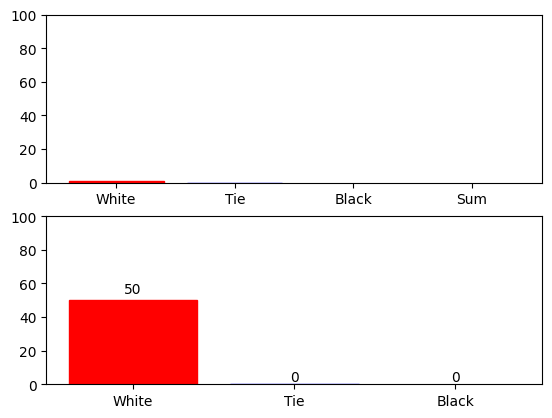

-------------------
Episode number: 1
The winner is White

+----------------------
| \ BLACK  BLACK  WHITE \
|   \                     \
|     \ EMPTY  WHITE  BLACK \
|       \                     \
|         \ EMPTY  WHITE  WHITE \
|          ---------------------|
|   BLACK |WHITE  EMPTY         |
|         |                     |
|       WHITE  EMPTY  WHITE     |
|         |                     |
|         | BLACK  EMPTY  EMPTY |
|         |                     |
 \ EMPTY  EMPTY  BLACK          |
   \      |                     |
     \ EMPTY  EMPTY  EMPTY      |
       \  |                     |
         \| EMPTY  BLACK  WHITE |
           ---------------------+


saved values
Episode number: 2
The winner is Black

+----------------------
| \ EMPTY  EMPTY  EMPTY \
|   \                     \
|     \ WHITE  EMPTY  EMPTY \
|       \                     \
|         \ EMPTY  EMPTY  BLACK \
|          ---------------------|
|   EMPTY |EMPTY  BLACK         |
|         |                  

In [20]:
game = TicTacToe('EasyAgent', 'DeepAgent', '/content/model_values_new.WHITE.h5', '/content/model_values_new.h5',0.5,0.5)
game.play_to_learn(10)

Episode number: 0
The winner is Black

+----------------------
| \ EMPTY  WHITE  EMPTY \
|   \                     \
|     \ EMPTY  EMPTY  EMPTY \
|       \                     \
|         \ BLACK  WHITE  BLACK \
|          ---------------------|
|   EMPTY |BLACK  EMPTY         |
|         |                     |
|       BLACK  BLACK  WHITE     |
|         |                     |
|         | EMPTY  WHITE  EMPTY |
|         |                     |
 \ BLACK  EMPTY  EMPTY          |
   \      |                     |
     \ WHITE  WHITE  EMPTY      |
       \  |                     |
         \| WHITE  BLACK  EMPTY |
           ---------------------+


Piece.BLACK
saved values


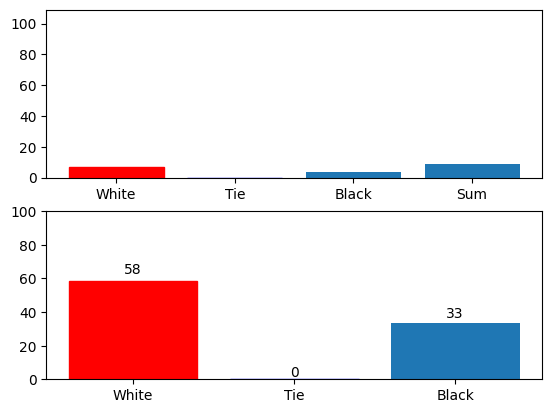

-------------------
Episode number: 1
The winner is White

+----------------------
| \ EMPTY  EMPTY  EMPTY \
|   \                     \
|     \ EMPTY  EMPTY  EMPTY \
|       \                     \
|         \ BLACK  EMPTY  EMPTY \
|          ---------------------|
|   WHITE |BLACK  BLACK         |
|         |                     |
|       BLACK  WHITE  WHITE     |
|         |                     |
|         | BLACK  WHITE  WHITE |
|         |                     |
 \ EMPTY  EMPTY  BLACK          |
   \      |                     |
     \ EMPTY  WHITE  BLACK      |
       \  |                     |
         \| WHITE  EMPTY  WHITE |
           ---------------------+


saved values
Episode number: 2
The winner is White

+----------------------
| \ BLACK  EMPTY  EMPTY \
|   \                     \
|     \ EMPTY  EMPTY  EMPTY \
|       \                     \
|         \ WHITE  EMPTY  EMPTY \
|          ---------------------|
|   EMPTY |EMPTY  EMPTY         |
|         |                  

In [21]:
game.play_to_learn(10)

In [32]:
game = TicTacToe('DeepAgent', 'DeepAgent', '/content/model_valuesPiece.WHITE.h5', '/content/model_valuesPiece3.WHITE.h5',1, 1)
game.play_to_learn(10)

loaded model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3584      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________
loaded model
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               3584      
                                                                 
 d

KeyboardInterrupt: ignored

In [ ]:
# game = TicTacToe('DeepAgent', 'EasyAgent', 1, 1)
# game.play_to_learn(10)

In [ ]:
game2 = TicTacToe('DeepAgent', 'EasyAgent', 1, 1)
game2.play_to_learn(10)

In [ ]:
game.play_to_learn(20)

In [ ]:
game.play_to_learn(20)